In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
X = mnist.data
y = mnist.target
X, y 

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

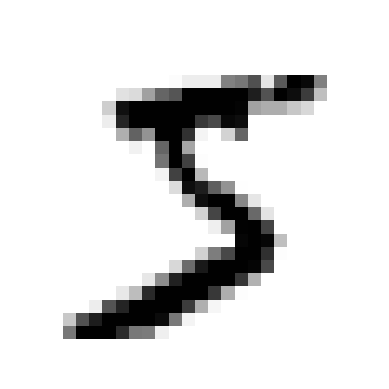

In [7]:
def plot_image(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]
plot_image(some_digit)
plt.show()

In [8]:
y[0]

'5'

# train test split
- dataset is already shuffled so we just split it directly

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# basic binary classification
- predicition weather data is 5 or non-5

In [15]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

In [16]:
# cross val score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

95% accuracy over all folds! Not really!
- The data has only 10% 5's so if the model gives prediction that all the input is non-5 then it will be 90% accurate thats why we dont use accuracy in classification tasks

# creating a confusion matrix(for predictions)

**cross_val_predict()** performs k-fold cross-validation, but instead of
returning the evaluation scores, it returns the predictions made on each test
fold. This means that you get a clean prediction for each instance in the
training set (by “clean” I mean “out-of-sample”: the model makes
predictions on data that it never saw during training).


In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,
cv=3)


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm


array([[53892,   687],
       [ 1891,  3530]])

### Note: 
Each row in a confusion matrix represents an actual class, while each
column represents a predicted class. The first row of this matrix considers
non-5 images (the negative class): 53,892 of them were correctly classified
as non-5s (they are called true negatives), while the remaining 687 were
wrongly classified as 5s (false positives, also called type I errors). The
second row considers the images of 5s (the positive class): 1,891 were A
perfect classifier would only have true positives and true negatives, so its
confusion matrix would have nonzero values only on its main diagonal

### confusion matrix with more info:
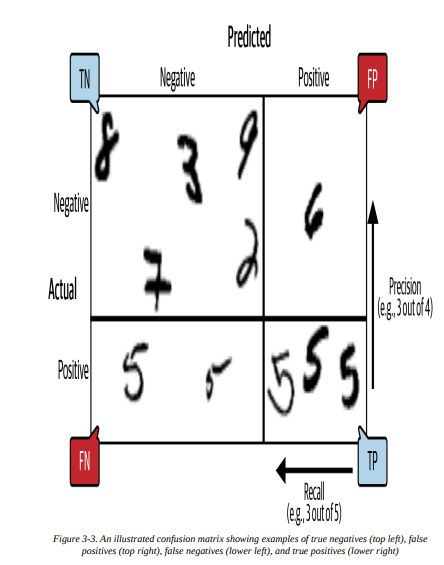

# precision, recall and f1 score

**precision:**  
Out of the data classified as True +ve how many were correct  
TP / (TP + FP)

**recall**  
from the total positive class how many were correctly classified  
TP / (TP + FN)

**f1 score**  
harmonic mean of precision and recall  
2 *  (precision * recall) / (precision + recall)

In [19]:
# decision function gives us the score for each input
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')


In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [23]:
threshold = 3000

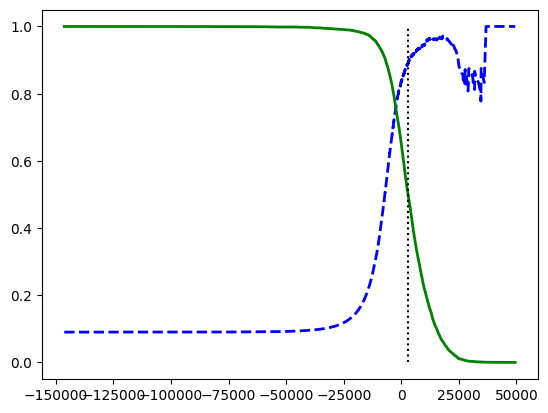

In [24]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision",
linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall",
linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

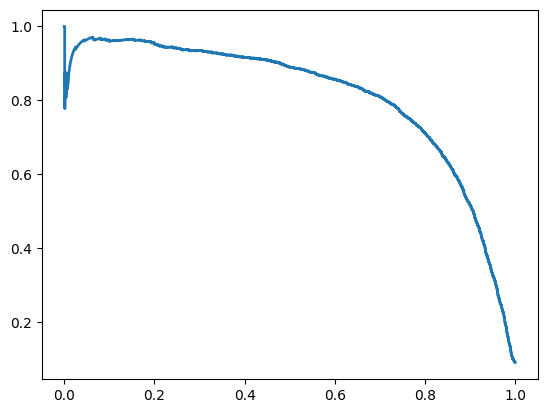

In [25]:
plt.plot(recalls, precisions, linewidth=2,
label="Precision/Recall curve")

### TIP:  
If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”


# ROC Curve

- The receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers.
- the ROC curve plots the true
positive rate (another name for recall) against the false positive rate (FPR).
The FPR (also called the fall-out) is the ratio of negative instances that are
incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified
as negative. The TNR is also called specificity. Hence, the ROC curve plots
**sensitivity (recall) versus 1 – specificity**.

- Laymen terms:
    - Jo recall value hai('sare +ve mein se kitne barabar pakde gaye')
    - vs
    - fall out('sare -ve mein se kitne falsly +ve classify hue')


In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


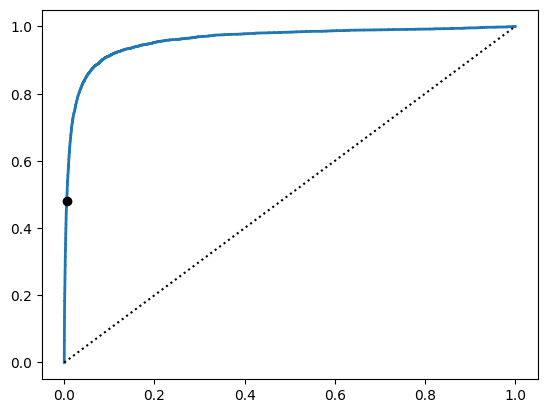

In [33]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

### observation:  
Once again there is a trade-off: the higher the recall (TPR), the more false
positives (FPR) the classifier produces

## ROC AUC
- How to compare classifiers? 
    - **ROC's Area under the curve**:
    - If the AUC of this curve is close to 1 its a good model and if it is near 0.5 then its bad
    - Sice 0.5 mean a diagonal line which even a RandomClassifier would get the same result

#### TIP
Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder
**how to decide which one to use**. As a rule of thumb, you should prefer the PR curve
whenever the positive class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve. For example, looking at the previous
ROC curve (and the ROC AUC score), you may think that the classifier is really good.
But this is mostly because there are few positives (5s) compared to the negatives (non5s). In contrast, the PR curve makes it clear that the classifier has room for
improvement